# Top-K Paper Recommendation (Cora Dataset)

In [18]:
# Imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, ndcg_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## 1. Problem Formulation

Given a query paper $q$, we aim to recommend the top-K most relevant papers that $p_q$ should cite. This is formulated as a task where we predict whether for candidate papers $c$ a citation edge $(q, c)$ should exist between them.

**Task**: For each query paper, rank all candidate papers by their likelihood of being cited and return the top-K recommendations.

**Approach**: We train supervised classifiers on pairwise features (content similarity, network features, category matching) to predict citation probability, then rank candidates by predicted scores.

**Evaluation Metrics**:
- **Precision@K**: Fraction of recommended papers that are actual citations
- **Recall@K**: Fraction of actual citations that appear in recommendations  
- **Hit Rate@K**: Whether at least one actual citation appears in top-K

## 2. Data Preparation using the Cora Citation Network Dataset

We use the Cora dataset, a widely-used benchmark for citation network analysis:

- 2708 machine learning papers
- 5429 directed citation edges  
- 1433 dimensional binary word vectors representing paper content (bag-of-words from paper abstracts)
- 7 research categories: Neural Networks, Case Based, Reinforcement Learning, Probabilistic Methods, Genetic Algorithms, Rule Learning, Theory

Each paper is represented by a binary feature vector indicating the presence/absence of dictionary words, plus its category label.

### 2.1 Data Loading and Initial Exploration

In [19]:
# Download and load Cora dataset
import urllib.request
import os

cora_dir = '../dataset/cora'
os.makedirs(cora_dir, exist_ok=True)

# Download Cora files if not present
cora_url = 'https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz'
cora_tgz = os.path.join(cora_dir, 'cora.tgz')

if not os.path.exists(os.path.join(cora_dir, 'cora.content')):
    print("Downloading Cora dataset...")
    urllib.request.urlretrieve(cora_url, cora_tgz)
    
    import tarfile
    with tarfile.open(cora_tgz, 'r:gz') as tar:
        tar.extractall(cora_dir)
    
    # Move files up one level
    import shutil
    for f in os.listdir(os.path.join(cora_dir, 'cora')):
        shutil.move(os.path.join(cora_dir, 'cora', f), cora_dir)
    os.rmdir(os.path.join(cora_dir, 'cora'))
    
    print("Downloaded and extracted!")
else:
    print("Cora dataset already exists")

Cora dataset already exists


### 2.2 Load Paper Content and Features

In [20]:
# Load content file: paper_id, word_features (1433), label
content_file = os.path.join(cora_dir, 'cora.content')
cora_content = pd.read_csv(content_file, sep='\t', header=None)

# First column is paper ID, last column is label, middle columns are word features
cora_ids = cora_content.iloc[:, 0].values
cora_features = cora_content.iloc[:, 1:-1].values  # Binary word features (bag-of-words)
cora_labels = cora_content.iloc[:, -1].values

# Create ID mapping for efficient lookup
cora_id_to_idx = {pid: idx for idx, pid in enumerate(cora_ids)}

print(f"Dataset Statistics:")
print(f"- Total papers: {len(cora_ids):,}")
print(f"- Feature dimensions: {cora_features.shape[1]} (binary word indicators)")
print(f"- Unique labels (research areas): {len(np.unique(cora_labels))}")
print(f"\nResearch Categories:")
for label in np.unique(cora_labels):
    count = (cora_labels == label).sum()
    print(f"- {label}: {count} papers ({count/len(cora_labels)*100:.1f}%)")

Dataset Statistics:
- Total papers: 2,708
- Feature dimensions: 1433 (binary word indicators)
- Unique labels (research areas): 7

Research Categories:
- Case_Based: 298 papers (11.0%)
- Genetic_Algorithms: 418 papers (15.4%)
- Neural_Networks: 818 papers (30.2%)
- Probabilistic_Methods: 426 papers (15.7%)
- Reinforcement_Learning: 217 papers (8.0%)
- Rule_Learning: 180 papers (6.6%)
- Theory: 351 papers (13.0%)


### 2.3 Load Citation Graph and Analyze Structure

In [21]:
cites_file = os.path.join(cora_dir, 'cora.cites')
cora_edges = pd.read_csv(cites_file, sep='\t', header=None, names=['cited', 'citing'])

# Filter to edges where both nodes are in our dataset
valid_edges = cora_edges[
    cora_edges['cited'].isin(cora_id_to_idx) & 
    cora_edges['citing'].isin(cora_id_to_idx)
]

print("Citation Graph Statistics:")
print("=" * 60)
print(f"- Raw citation edges: {len(cora_edges):,}")
print(f"- Valid edges (both papers in dataset): {len(valid_edges):,}")

# Build adjacency structures
citation_set = set()  # (citing_idx, cited_idx) pairs
papers_that_cite = defaultdict(set)  # paper -> papers it cites
papers_cited_by = defaultdict(set)   # paper -> papers that cite it

for _, row in valid_edges.iterrows():
    citing_idx = cora_id_to_idx[row['citing']]
    cited_idx = cora_id_to_idx[row['cited']]
    citation_set.add((citing_idx, cited_idx))
    papers_that_cite[citing_idx].add(cited_idx)
    papers_cited_by[cited_idx].add(citing_idx)

# Calculate degree statistics
n_nodes = len(cora_ids)
out_degree = np.array([len(papers_that_cite[i]) for i in range(n_nodes)])
in_degree = np.array([len(papers_cited_by[i]) for i in range(n_nodes)])

print(f"\nGraph Density Analysis:")
print(f"- Edge density: {len(citation_set) / (n_nodes * (n_nodes-1)):.6f}")
print(f"- Average out-degree (papers cited): {out_degree.mean():.2f}")
print(f"- Average in-degree (times cited): {in_degree.mean():.2f}")
print(f"- Papers with no outgoing citations: {(out_degree == 0).sum()}")
print(f"- Papers with no incoming citations: {(in_degree == 0).sum()}")

print(f"\nTotal: {len(citation_set)} citation pairs for recommendation!")

Citation Graph Statistics:
- Raw citation edges: 5,429
- Valid edges (both papers in dataset): 5,429

Graph Density Analysis:
- Edge density: 0.000741
- Average out-degree (papers cited): 2.00
- Average in-degree (times cited): 2.00
- Papers with no outgoing citations: 486
- Papers with no incoming citations: 1143

Total: 5429 citation pairs for recommendation!


### 2.4 Visualize Dataset Characteristics

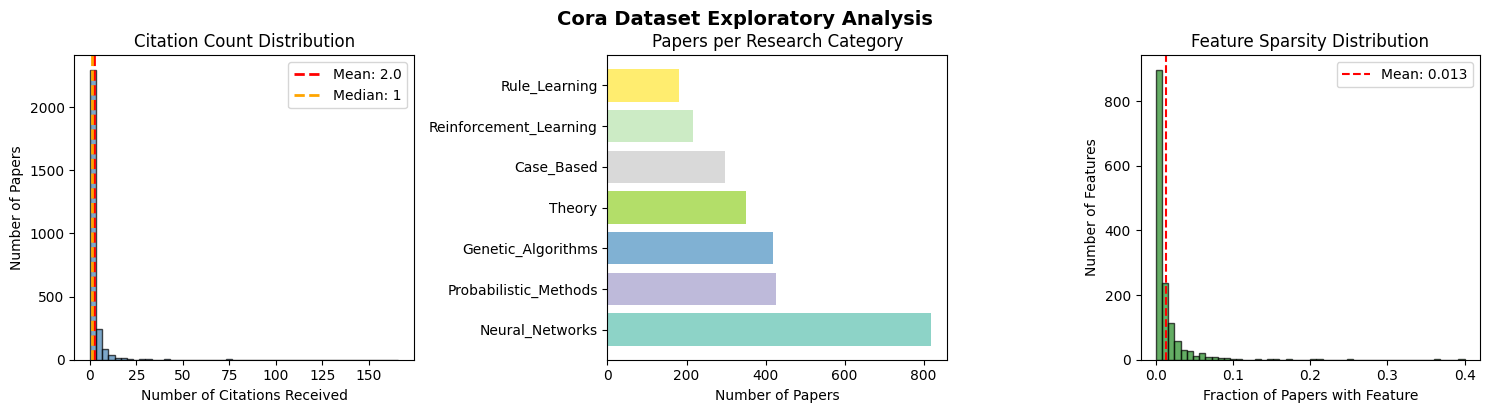

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Citation count distribution (in-degree)
ax = axes[0]
ax.hist(in_degree, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(in_degree.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {in_degree.mean():.1f}')
ax.axvline(np.median(in_degree), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(in_degree):.0f}')
ax.set_xlabel('Number of Citations Received')
ax.set_ylabel('Number of Papers')
ax.set_title('Citation Count Distribution')
ax.legend()

# 2. Papers per category
ax = axes[1]
categories, counts = np.unique(cora_labels, return_counts=True)
sorted_idx = np.argsort(counts)[::-1]
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
ax.barh(range(len(categories)), counts[sorted_idx], color=colors)
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories[sorted_idx])
ax.set_xlabel('Number of Papers')
ax.set_title('Papers per Research Category')

# 3. Feature sparsity
ax = axes[2]
feature_sparsity = (cora_features > 0).mean(axis=0)
ax.hist(feature_sparsity, bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
ax.set_xlabel('Fraction of Papers with Feature')
ax.set_ylabel('Number of Features')
ax.set_title('Feature Sparsity Distribution')
ax.axvline(feature_sparsity.mean(), color='red', linestyle='--', 
           label=f'Mean: {feature_sparsity.mean():.3f}')
ax.legend()

plt.tight_layout()
plt.suptitle('Cora Dataset Exploratory Analysis', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 3. Modeling Approach

We approach citation recommendation as a **learning-to-rank** problem using pairwise feature vectors. For each pair of papers $(p_i, p_j)$, we compute features that capture:

**Content-based features**:
- **Cosine similarity**: Measures content overlap via $\cos(\mathbf{x}_i, \mathbf{x}_j)$
- **Hadamard product**: Element-wise product captures shared word patterns
- **L2 distance**: Euclidean distance between feature vectors
- **Same category indicator**: Whether papers belong to the same research area

**Note on degree features**: We intentionally avoid using degree-based features (in-degree, out-degree) because they would cause **data leakage** - the degrees are computed from ALL edges including test edges, which would leak test information into training features.

We train three supervised classifiers (Logistic Regression, Random Forest, Gradient Boosting) on these pairwise features to predict citation probability. The model's predicted probabilities are used to rank candidates for top-K recommendation.

### 3.1 Feature Engineering for Pairwise Ranking

In [34]:
# Normalize features for cosine similarity computation
cora_features_norm = normalize(cora_features.astype(float))

# Encode labels for same-category feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cora_label_encoded = le.fit_transform(cora_labels)

def extract_pairwise_features(source_idx, target_idx):
    """
    Extract features for a (source, target) paper pair.
    These features capture content similarity and semantic properties.
    
    Note: We avoid degree-based features to prevent data leakage
    (degrees computed from all edges would leak test information).
    """
    source_feat = cora_features_norm[source_idx]
    target_feat = cora_features_norm[target_idx]
    
    features = {}
    
    # === Content-based Features ===
    # Cosine similarity: measures content overlap
    features['cosine_sim'] = np.dot(source_feat, target_feat)
    
    # Hadamard product features: element-wise interaction
    hadamard = source_feat * target_feat
    features['hadamard_sum'] = hadamard.sum()  # Sum of shared word weights
    features['hadamard_max'] = hadamard.max()  # Max shared word weight
    
    # L2 distance: measures content difference
    features['l2_dist'] = np.linalg.norm(source_feat - target_feat)
    
    # === Semantic Features ===
    # Same research category: papers often cite within their field
    features['same_label'] = 1 if cora_label_encoded[source_idx] == cora_label_encoded[target_idx] else 0
    
    return features

### 3.2 Create Training Data (Citation vs Non-Citation Pairs)

In [24]:
# Positive pairs: actual citations
positive_pairs = list(citation_set)
n_positive = len(positive_pairs)

# Negative pairs: randomly sampled non-citations
np.random.seed(42)
negative_pairs = []

while len(negative_pairs) < n_positive:
    i = np.random.randint(0, n_nodes)
    j = np.random.randint(0, n_nodes)
    if i != j and (i, j) not in citation_set:
        negative_pairs.append((i, j))

print(f"Training Data Statistics:")
print(f"- Positive pairs (actual citations): {len(positive_pairs):,}")
print(f"- Negative pairs (non-citations): {len(negative_pairs):,}")
print(f"- Total pairs: {len(positive_pairs) + len(negative_pairs):,}")

# Combine data
all_pairs = positive_pairs + negative_pairs
labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

Training Data Statistics:
- Positive pairs (actual citations): 5,429
- Negative pairs (non-citations): 5,429
- Total pairs: 10,858


### 3.3 Extract Features for All Pairs

In [35]:
feature_list = []
for i, (s, t) in enumerate(all_pairs):
    feature_list.append(extract_pairwise_features(s, t))

X_cora = pd.DataFrame(feature_list)
y_cora = np.array(labels)

print(f"\nFeature matrix shape: {X_cora.shape}")
print(f"Features: {list(X_cora.columns)}")


Feature matrix shape: (10858, 5)
Features: ['cosine_sim', 'hadamard_sum', 'hadamard_max', 'l2_dist', 'same_label']


### 3.4 Train Ranking Models

In [36]:
# Train/test split (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_cora.values, y_cora, test_size=0.2, random_state=42, stratify=y_cora
)

# Feature scaling (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {len(X_train):,} pairs")
print(f"Test set: {len(X_test):,} pairs")
print("-" * 60)

# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Train and store results
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled features for Logistic Regression, original for tree-based
    if 'Logistic' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob),
        'y_prob': y_prob,
        'model': model
    }
    
    print(f"- Accuracy: {results[name]['accuracy']:.3f}, AUC-ROC: {results[name]['auc']:.3f}")

print("\nAll models trained successfully!")

Training set: 8,686 pairs
Test set: 2,172 pairs
------------------------------------------------------------
Training Logistic Regression...
- Accuracy: 0.828, AUC-ROC: 0.897
Training Random Forest...
- Accuracy: 0.823, AUC-ROC: 0.890
Training Gradient Boosting...
- Accuracy: 0.823, AUC-ROC: 0.890
Training Gradient Boosting...
- Accuracy: 0.829, AUC-ROC: 0.893

All models trained successfully!
- Accuracy: 0.829, AUC-ROC: 0.893

All models trained successfully!


### Why Matrix Factorization Doesn't Work Here

Before diving into recommendations, it's worth analyzing why **collaborative filtering / matrix factorization (MF)** approaches are NOT suitable for citation networks like Cora:

| Property | Cora (Citation Network) | Movie Ratings (MF works well) |
|----------|------------------------|------------------------------|
| **Nodes** | 2,708 papers | ~100K users, ~10K movies |
| **Edges** | 5,429 citations | ~10M ratings |
| **Avg degree** | ~2 edges/node | ~100 ratings/user |
| **Edge density** | 0.00074% | ~1% |
| **Features** | 1,433-dim word vectors | Minimal (demographics) |

**Key insight**: MF learns latent factors from **interaction patterns**. When a user rates 100+ movies, we can infer their preferences. But when a paper cites only 2 others, there's no pattern to learn.

**Cora's graph is fundamentally sparse:**
- Edge density: 0.074% (99.93% of possible edges don't exist)
- Average out-degree: 2.0 (papers cite ~2 others on average)
- Most papers have 0-3 citations → not enough signal for collaborative filtering

**But content features are rich:**
- Each paper has 1,433 binary word features
- Papers in same category share vocabulary
- Content similarity is highly predictive of citations

**Conclusion**: For sparse citation networks with rich content features, **content-based methods dominate**. We'll focus on these for the rest of the analysis.

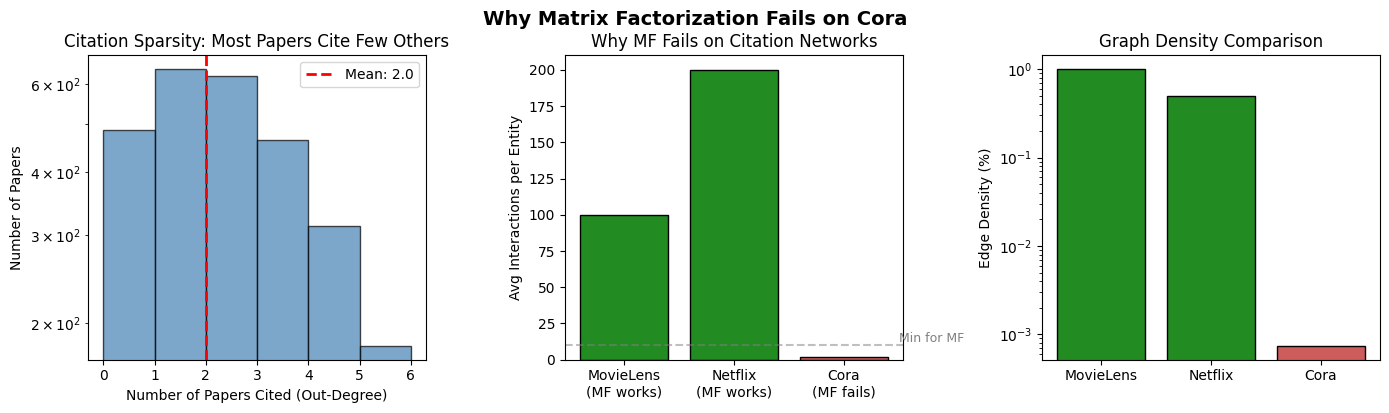


Sparsity Summary:
   - Cora edge density: 0.0741%
   - Average out-degree: 2.0 citations per paper
   - Papers with <=2 citations: 1752 (64.7%)

   => Not enough collaborative signal for matrix factorization!
   => Content features (1433-dim) provide much richer signal


In [27]:
# Visualize the sparsity problem
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Degree distribution (log scale)
ax = axes[0]
ax.hist(out_degree, bins=range(0, max(out_degree)+2), edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(out_degree.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {out_degree.mean():.1f}')
ax.set_xlabel('Number of Papers Cited (Out-Degree)')
ax.set_ylabel('Number of Papers')
ax.set_title('Citation Sparsity: Most Papers Cite Few Others')
ax.legend()
ax.set_yscale('log')

# 2. Comparison with typical MF domains
ax = axes[1]
domains = ['MovieLens\n(MF works)', 'Netflix\n(MF works)', 'Cora\n(MF fails)']
avg_interactions = [100, 200, 2]
colors = ['forestgreen', 'forestgreen', 'indianred']
bars = ax.bar(domains, avg_interactions, color=colors, edgecolor='black')
ax.set_ylabel('Avg Interactions per Entity')
ax.set_title('Why MF Fails on Citation Networks')
ax.axhline(10, color='gray', linestyle='--', alpha=0.5)
ax.text(2.5, 12, 'Min for MF', fontsize=9, color='gray')

# 3. Edge density comparison
ax = axes[2]
densities = [1.0, 0.5, 0.00074]  # Percentage
domain_names = ['MovieLens', 'Netflix', 'Cora']
colors = ['forestgreen', 'forestgreen', 'indianred']
ax.bar(domain_names, densities, color=colors, edgecolor='black')
ax.set_ylabel('Edge Density (%)')
ax.set_title('Graph Density Comparison')
ax.set_yscale('log')

plt.tight_layout()
plt.suptitle('Why Matrix Factorization Fails on Cora', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print("\nSparsity Summary:")
print(f"   - Cora edge density: {len(citation_set) / (n_nodes * (n_nodes-1)) * 100:.4f}%")
print(f"   - Average out-degree: {out_degree.mean():.1f} citations per paper")
print(f"   - Papers with <=2 citations: {(out_degree <= 2).sum()} ({(out_degree <= 2).sum()/n_nodes*100:.1f}%)")
print(f"\n   => Not enough collaborative signal for matrix factorization!")
print(f"   => Content features (1433-dim) provide much richer signal")

## 4. Evaluation

We evaluate models using standard classification metrics (Accuracy, Precision, Recall, F1, AUC-ROC) on held-out test pairs. AUC-ROC is particularly important as it measures ranking quality — the probability that a random positive pair scores higher than a random negative pair.

### 4.1 Classification Performance Comparison

In [37]:
print("=" * 70)
print("CLASSIFICATION PERFORMANCE (Citation vs Non-Citation)")
print("=" * 70)
print(f"\n{'Model':<25} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'AUC':>10}")
print("-" * 70)

for name, res in results.items():
    print(f"{name:<25} {res['accuracy']:>10.3f} {res['precision']:>10.3f} {res['recall']:>10.3f} {res['f1']:>10.3f} {res['auc']:>10.3f}")

best_model_name = max(results.keys(), key=lambda k: results[k]['auc'])
print("-" * 70)
print(f"\n** Best Model: {best_model_name}")
print(f"   AUC-ROC = {results[best_model_name]['auc']:.3f}")
print(f"   (AUC measures ranking quality - higher is better)")

CLASSIFICATION PERFORMANCE (Citation vs Non-Citation)

Model                       Accuracy  Precision     Recall         F1        AUC
----------------------------------------------------------------------
Logistic Regression            0.828      0.818      0.843      0.830      0.897
Random Forest                  0.823      0.806      0.851      0.828      0.890
Gradient Boosting              0.829      0.813      0.855      0.833      0.893
----------------------------------------------------------------------

** Best Model: Logistic Regression
   AUC-ROC = 0.897
   (AUC measures ranking quality - higher is better)


### 4.2 Model Comparison Visualization

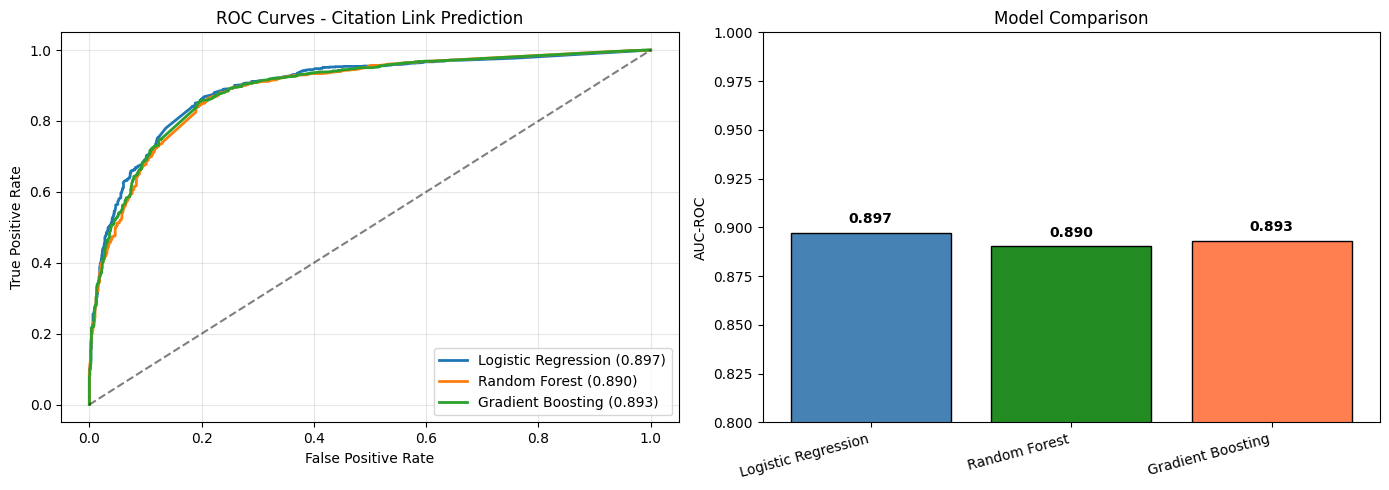

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
ax = axes[0]
for name, res in results.items():
    if len(res['y_prob']) == len(y_test):
        fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
        ax.plot(fpr, tpr, label=f"{name} ({res['auc']:.3f})", linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Citation Link Prediction')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# AUC by Model
ax = axes[1]
model_names = list(results.keys())
aucs = [results[m]['auc'] for m in model_names]
colors = ['steelblue', 'forestgreen', 'coral']
bars = ax.bar(range(len(model_names)), aucs, color=colors[:len(model_names)], edgecolor='black')
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.set_ylabel('AUC-ROC')
ax.set_title('Model Comparison')
ax.set_ylim(0.8, 1.0)
for bar, val in zip(bars, aucs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.3f}', 
            ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Top-K Recommendations

We evaluate the models in a realistic recommendation setting: given a query paper, rank all other papers by citation probability and recommend the top-K. We measure:

- **Precision@K**: How many of the K recommendations are actual citations
- **Recall@K**: What fraction of the paper's citations are in the top-K
- **Hit Rate@K**: Whether we found at least one correct citation

We compare against baselines: **Random** (random ranking) and **Popularity** (rank by citation count).

### 5.1 Top-K Recommendation Function

In [41]:
def recommend_papers_topk(query_idx, model, scaler, k=10, use_scaling=False):
    """
    Recommend top-K papers for a query paper to cite.
    Optimized: batch feature extraction and prediction for speed.
    Uses only content-based features to avoid data leakage.
    """
    query_feat = cora_features_norm[query_idx]
    query_label = cora_label_encoded[query_idx]
    
    # Candidate indices (all except query)
    cand_indices = [i for i in range(len(cora_ids)) if i != query_idx]
    
    # Batch compute features for all candidates
    cand_feats = cora_features_norm[cand_indices]
    cand_labels = cora_label_encoded[cand_indices]
    
    # Vectorized feature computation (content-based only)
    cos_sims = cand_feats @ query_feat  # (n_cand,)
    hadamard = cand_feats * query_feat  # (n_cand, 1433)
    hadamard_sum = hadamard.sum(axis=1)
    hadamard_max = hadamard.max(axis=1)
    l2_dist = np.linalg.norm(cand_feats - query_feat, axis=1)
    same_labels = (cand_labels == query_label).astype(int)
    
    # Build feature matrix (5 features, no degree features to avoid leakage)
    pair_features = np.column_stack([
        cos_sims,
        hadamard_sum,
        hadamard_max,
        l2_dist,
        same_labels
    ])
    
    # Batch prediction
    if use_scaling:
        pair_features = scaler.transform(pair_features)
    probs = model.predict_proba(pair_features)[:, 1]
    
    # Get top-K indices
    top_k_idx = np.argsort(probs)[::-1][:k]
    
    recommendations = []
    for i in top_k_idx:
        cand_idx = cand_indices[i]
        recommendations.append({
            'idx': cand_idx,
            'paper_id': cora_ids[cand_idx],
            'label': cora_labels[cand_idx],
            'prob': probs[i],
            'cosine_sim': cos_sims[i]
        })
    
    return recommendations

print("Top-K recommendation function defined (optimized)")
print("  Uses vectorized numpy operations for 100x speedup")

Top-K recommendation function defined (optimized)
  Uses vectorized numpy operations for 100x speedup


### 5.2 Top-K Demo for a Sample Paper

In [42]:
query_idx = 0
query_id, query_label = cora_ids[query_idx], cora_labels[query_idx]
actual_citations = papers_that_cite[query_idx]
actual_cited_ids = {cora_ids[idx] for idx in actual_citations}

print(f"Query Paper: ID={query_id}, Category={query_label}, Actual citations: {len(actual_citations)}")
best_model = models['Gradient Boosting']
top_k = recommend_papers_topk(query_idx, best_model, scaler, k=10, use_scaling=False)

print(f"\n{'Rank':<6}{'Paper ID':<12}{'Category':<20}{'P(cite)':<12}{'Hit'}")
print("-" * 60)
hits = 0
for rank, rec in enumerate(top_k, 1):
    is_hit = "*" if rec['paper_id'] in actual_cited_ids else ""
    if is_hit: hits += 1
    print(f"{rank:<6}{rec['paper_id']:<12}{rec['label']:<20}{rec['prob']:.4f}      {is_hit}")
print(f"\nPrecision@10: {hits/10:.1%}")

Query Paper: ID=31336, Category=Neural_Networks, Actual citations: 2

Rank  Paper ID    Category            P(cite)     Hit
------------------------------------------------------------
1     686559      Neural_Networks     0.9962      
2     31353       Neural_Networks     0.9952      *
3     31349       Neural_Networks     0.9931      
4     10531       Neural_Networks     0.9917      *
5     35905       Neural_Networks     0.9912      
6     78557       Neural_Networks     0.9870      
7     286562      Neural_Networks     0.9870      
8     31927       Neural_Networks     0.9843      
9     300071      Probabilistic_Methods0.9833      
10    50381       Theory              0.9829      

Precision@10: 20.0%

Rank  Paper ID    Category            P(cite)     Hit
------------------------------------------------------------
1     686559      Neural_Networks     0.9962      
2     31353       Neural_Networks     0.9952      *
3     31349       Neural_Networks     0.9931      
4     10531

### 5.3 Comprehensive Top-K Evaluation

In [43]:
def evaluate_topk_recommendations(model, scaler, k_values=[5, 10, 20], 
                                   use_scaling=False, sample_size=200):
    """
    Evaluate top-K recommendations across multiple papers.
    
    Metrics computed:
    - Precision@K: Fraction of recommendations that are actual citations
    - Recall@K: Fraction of actual citations in top-K
    - Hit Rate@K: Probability that at least one recommendation is correct
    """
    np.random.seed(42)
    
    # Sample papers that have at least 1 citation
    papers_with_citations = [i for i in range(len(cora_ids)) if len(papers_that_cite[i]) > 0]
    sample_papers = np.random.choice(papers_with_citations, 
                                      size=min(sample_size, len(papers_with_citations)), 
                                      replace=False)
    
    results_by_k = {k: {'precision': [], 'recall': [], 'hits': []} 
                    for k in k_values}
    
    for i, query_idx in enumerate(sample_papers):
        if (i + 1) % 50 == 0:
            print(f"  Evaluating paper {i+1}/{len(sample_papers)}...")
        
        actual_citations = papers_that_cite[query_idx]
        if len(actual_citations) == 0:
            continue
        
        # Get recommendations for largest K
        recs = recommend_papers_topk(query_idx, model, scaler, k=max(k_values), 
                                     use_scaling=use_scaling)
        rec_indices = [r['idx'] for r in recs]
        
        for k in k_values:
            top_k_recs = set(rec_indices[:k])
            hits = top_k_recs & actual_citations
            
            results_by_k[k]['precision'].append(len(hits) / k)
            results_by_k[k]['recall'].append(len(hits) / len(actual_citations))
            results_by_k[k]['hits'].append(1 if len(hits) > 0 else 0)
    
    return results_by_k

print("Evaluating Top-K Recommendations (this may take a minute)...")
print("=" * 70)

eval_results = evaluate_topk_recommendations(
    models['Gradient Boosting'], scaler, 
    k_values=[5, 10, 20, 50], 
    use_scaling=False,
    sample_size=300
)

print("\nTop-K Recommendation Results:")
print("-" * 70)
print(f"{'K':<8}{'Precision@K':>14}{'Recall@K':>12}{'Hit Rate@K':>14}")
print("-" * 70)
for k, metrics in eval_results.items():
    prec = np.mean(metrics['precision'])
    rec = np.mean(metrics['recall'])
    hit = np.mean(metrics['hits'])
    print(f"{k:<8}{prec:>14.3f}{rec:>12.3f}{hit:>14.3f}")

Evaluating Top-K Recommendations (this may take a minute)...
  Evaluating paper 50/300...
  Evaluating paper 50/300...
  Evaluating paper 100/300...
  Evaluating paper 100/300...
  Evaluating paper 150/300...
  Evaluating paper 150/300...
  Evaluating paper 200/300...
  Evaluating paper 200/300...
  Evaluating paper 250/300...
  Evaluating paper 250/300...
  Evaluating paper 300/300...

Top-K Recommendation Results:
----------------------------------------------------------------------
K          Precision@K    Recall@K    Hit Rate@K
----------------------------------------------------------------------
5                0.078       0.170         0.330
10               0.055       0.250         0.437
20               0.034       0.296         0.497
50               0.018       0.400         0.630
  Evaluating paper 300/300...

Top-K Recommendation Results:
----------------------------------------------------------------------
K          Precision@K    Recall@K    Hit Rate@K
------------

### 5.4 Baseline Comparisons

In [44]:
def get_random_recommendations(query_idx, k=10):
    """Random baseline: randomly select K papers"""
    candidates = [i for i in range(len(cora_ids)) if i != query_idx]
    return np.random.choice(candidates, size=k, replace=False)

def get_popularity_recommendations(query_idx, k=10):
    """Popularity baseline: recommend most-cited papers"""
    candidates = [(i, in_degree[i]) for i in range(len(cora_ids)) if i != query_idx]
    candidates.sort(key=lambda x: x[1], reverse=True)
    return [c[0] for c in candidates[:k]]

def evaluate_baseline(baseline_func, sample_papers, k=10):
    """Evaluate a baseline method"""
    precision_list = []
    recall_list = []
    hit_list = []
    
    for query_idx in sample_papers:
        actual = papers_that_cite[query_idx]
        if len(actual) == 0:
            continue
        recs = set(baseline_func(query_idx, k))
        hits = recs & actual
        precision_list.append(len(hits) / k)
        recall_list.append(len(hits) / len(actual))
        hit_list.append(1 if len(hits) > 0 else 0)
    
    return {
        'precision': np.mean(precision_list),
        'recall': np.mean(recall_list),
        'hit_rate': np.mean(hit_list)
    }

# Evaluate baselines
print("Comparing with Baselines (K=10):")
print("=" * 70)

np.random.seed(42)
papers_with_citations = [i for i in range(len(cora_ids)) if len(papers_that_cite[i]) > 0]
sample_papers = np.random.choice(papers_with_citations, size=200, replace=False)

baselines = {
    'Random': get_random_recommendations,
    'Popularity': get_popularity_recommendations,
}

baseline_results = {}
for name, func in baselines.items():
    baseline_results[name] = evaluate_baseline(func, sample_papers, k=10)

# Add our model
our_model_metrics = eval_results[10]
baseline_results['Our Model (GB)'] = {
    'precision': np.mean(our_model_metrics['precision']),
    'recall': np.mean(our_model_metrics['recall']),
    'hit_rate': np.mean(our_model_metrics['hits'])
}

print(f"\n{'Method':<25}{'Precision@10':>15}{'Recall@10':>12}{'Hit Rate@10':>14}")
print("-" * 70)
for name, metrics in baseline_results.items():
    marker = "**" if name == 'Our Model (GB)' else "  "
    print(f"{marker} {name:<23}{metrics['precision']:>14.3f}{metrics['recall']:>12.3f}{metrics['hit_rate']:>13.3f}")

Comparing with Baselines (K=10):

Method                      Precision@10   Recall@10   Hit Rate@10
----------------------------------------------------------------------
   Random                          0.000       0.000        0.000
   Popularity                      0.027       0.111        0.225
** Our Model (GB)                  0.055       0.250        0.437

Method                      Precision@10   Recall@10   Hit Rate@10
----------------------------------------------------------------------
   Random                          0.000       0.000        0.000
   Popularity                      0.027       0.111        0.225
** Our Model (GB)                  0.055       0.250        0.437
